.# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [2]:
# import libraries
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier, plot_importance
import re
import nltk
import shap

from sqlalchemy import create_engine
nltk.download(['punkt', 'wordnet', 'averaged_perceptron_tagger'])
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, make_scorer
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from lime import lime_text
from lime.lime_text import LimeTextExplainer 

[nltk_data] Downloading package punkt to C:\Users\Chris
[nltk_data]     Cochet\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Chris
[nltk_data]     Cochet\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Chris Cochet\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
# load data from database
engine = create_engine('sqlite:///data/disaster-message.db')

df = pd.read_sql_query("SELECT * FROM messages", con = engine)
df = df.set_index('id')
X = df.drop('genre', axis = 1)
Y = df.iloc[:,2]

In [4]:
display(df.head(2), X.head(2), Y.head(2))

,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
id,,,,,,,,,,,,,,,,,,,,,
2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,0,...,0,0,1,0,1,0,0,0,0,0


,message,original,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
id,,,,,,,,,,,,,,,,,,,,,
2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,1,0,0,1,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0


id
2    direct
7    direct
Name: genre, dtype: object

### 2. Write a tokenization function to process your text data

In [5]:
def tokenize(text):
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()

    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)

    return clean_tokens

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer

# pipeline = Pipeline([
#         ('features', FeatureUnion([

#             ('text_pipeline', Pipeline([
#                 ('vect', CountVectorizer(tokenizer=tokenize)),
#                 ('tfidf', TfidfTransformer())
#             ])),

#             ('starting_verb', StartingVerbExtractor())
#         ])),

#         ('clf', RandomForestClassifier())
#     ])

nlp_pipeline_rf = Pipeline([
                        ('vect', CountVectorizer(tokenizer=tokenize)),
                        ('tfidf', TfidfTransformer()),
                        ('multiclassifier',MultiOutputClassifier(RandomForestClassifier()))
                    ])

nlp_pipeline_gb = Pipeline([
                        ('vect', CountVectorizer(tokenizer=tokenize)),
                        ('tfidf', TfidfTransformer()),
                        ('multiclassifier',MultiOutputClassifier(GradientBoostingClassifier()))
                    ])

nlp_pipeline_knn = Pipeline([
                        ('vect', CountVectorizer(tokenizer=tokenize)),
                        ('tfidf', TfidfTransformer()),
                        ('multiclassifier',MultiOutputClassifier(KNeighborsClassifier()))
                    ])

nlp_pipeline_simple_rf = Pipeline([
                        ('vect', CountVectorizer(tokenizer=tokenize)),
                        ('tfidf', TfidfTransformer()),
                        ('multiclassifier',RandomForestClassifier())
                    ])

nlp_pipeline_simple_gb = Pipeline([
                        ('vect', CountVectorizer(tokenizer=tokenize)),|
                        ('tfidf', TfidfTransformer()),
                        ('multiclassifier',GradientBoostingClassifier())
                    ])

nlp_pipeline_simple_lgb = Pipeline([
                        ('vect', CountVectorizer(tokenizer=tokenize)),
                        ('tfidf', TfidfTransformer()),
                        ('multiclassifier',LGBMClassifier(n_jobs=-1))
                    ])

nlp_pipeline_simple_lgb2 = Pipeline([
                        ('tfidfvect', TfidfVectorizer(tokenizer=tokenize)),
                        ('multiclassifier',LGBMClassifier(n_jobs=-1))
                    ])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [6]:
input_X = X['message']
#input_Y = pd.get_dummies(Y)

#X_train, X_test, y_train, y_test = train_test_split(input_X, input_Y)
#nlp_pipeline_rf.fit(X_train, y_train)

In [9]:
nlp_pipeline_gb.fit(X_train, y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(tokenizer=<function tokenize at 0x00000292B110AF28>)),
                ('tfidf', TfidfTransformer()),
                ('multiclassifier',
                 MultiOutputClassifier(estimator=GradientBoostingClassifier()))])

In [139]:
nlp_pipeline_knn.fit(X_train, y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(tokenizer=<function tokenize at 0x000002202F726C80>)),
                ('tfidf', TfidfTransformer()),
                ('multiclassifier',
                 MultiOutputClassifier(estimator=KNeighborsClassifier()))])

In [136]:
# imports 
from sklearn import set_config                      # to change the display
from sklearn.utils import estimator_html_repr       # to save the diagram into HTML format

# set config to diagram for visualizing the pipelines/composite estimators
set_config(display='diagram')

nlp_pipeline_knn

Pipeline(steps=[('vect',
                 CountVectorizer(tokenizer=<function tokenize at 0x00000292B110AF28>)),
                ('tfidf', TfidfTransformer()),
                ('multiclassifier',
                 MultiOutputClassifier(estimator=KNeighborsClassifier()))])

In [6]:
nlp_pipeline_simple_lgb

Pipeline(steps=[('vect',
                 CountVectorizer(tokenizer=<function tokenize at 0x000002049E61BD90>)),
                ('tfidf', TfidfTransformer()),
                ('multiclassifier', LGBMClassifier())])

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [134]:
def display_results(y_test, y_pred, model_name):
    labels = np.unique(y_pred)
    #confusion_mat = confusion_matrix(y_test, y_pred, labels=labels)
    f_score = f1_score(y_test,y_pred, average='weighted')
    accuracy = (y_pred == y_test).mean()

    print("Model :",model_name)
    print("Labels:", labels)
#    print("Confusion Matrix:\n", confusion_mat)
    print("F1 Score:", f_score)
    print("Accuracy:", accuracy)

In [141]:
# predict on test data

y_pred = nlp_pipeline_rf.predict(X_test)
# display results
display_results(y_test, y_pred, "RandomForestClassifier")

y_pred = nlp_pipeline_gb.predict(X_test)
# display results
display_results(y_test, y_pred, "GradientBoostingClassifier")

y_pred = nlp_pipeline_knn.predict(X_test)
# display results
display_results(y_test, y_pred, "KNeighborsClassifier")

Model : RandomForestClassifier
Labels: [0 1]
F1 Score: 0.9496818744760687
Accuracy: direct    0.951938
news      0.969637
social    0.979554
dtype: float64
Model : GradientBoostingClassifier
Labels: [0 1]
F1 Score: 0.9396907967824928
Accuracy: direct    0.938969
news      0.956973
social    0.983827
dtype: float64
Model : KNeighborsClassifier
Labels: [0 1]
F1 Score: 0.8788030813267635
Accuracy: direct    0.884193
news      0.909521
social    0.965365
dtype: float64


In [178]:


scores = cross_val_score(
    nlp_pipeline_rf,
    input_X, input_Y,
    scoring='f1_weighted',
    cv=5)

In [179]:
scores.mean()

0.8649608122053211

In [172]:
scores = cross_val_score(
    nlp_pipeline_gb,
    input_X, input_Y,
    scoring='f1_weighted',
     cv=5)

In [173]:
scores.mean()

0.8563593495138049

In [183]:
scores = cross_val_score(
    nlp_pipeline_knn,
    input_X, input_Y,
    scoring='f1_weighted',
     cv=5)

In [184]:
scores.mean()

0.7838622323347498

In [11]:
scores = cross_val_score(
    nlp_pipeline_simple_lgb,
    input_X, Y,
    scoring='f1_weighted',
     cv=5)

In [12]:
scores.mean()

0.9539885697356878

In [60]:
scores = cross_val_score(
    nlp_pipeline_simple_lgb2,
    input_X, Y,
    scoring='f1_weighted',
     cv=5)

In [61]:
scores.mean()

0.9539885697356878

### 6. Improve your model
Use grid search to find better parameters. 

In [62]:
nlp_pipeline_simple_lgb2.get_params()

{'memory': None,
 'steps': [('tfidfvect',
   TfidfVectorizer(tokenizer=<function tokenize at 0x000002049E61BD90>)),
  ('multiclassifier', LGBMClassifier())],
 'verbose': False,
 'tfidfvect': TfidfVectorizer(tokenizer=<function tokenize at 0x000002049E61BD90>),
 'multiclassifier': LGBMClassifier(),
 'tfidfvect__analyzer': 'word',
 'tfidfvect__binary': False,
 'tfidfvect__decode_error': 'strict',
 'tfidfvect__dtype': numpy.float64,
 'tfidfvect__encoding': 'utf-8',
 'tfidfvect__input': 'content',
 'tfidfvect__lowercase': True,
 'tfidfvect__max_df': 1.0,
 'tfidfvect__max_features': None,
 'tfidfvect__min_df': 1,
 'tfidfvect__ngram_range': (1, 1),
 'tfidfvect__norm': 'l2',
 'tfidfvect__preprocessor': None,
 'tfidfvect__smooth_idf': True,
 'tfidfvect__stop_words': None,
 'tfidfvect__strip_accents': None,
 'tfidfvect__sublinear_tf': False,
 'tfidfvect__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tfidfvect__tokenizer': <function __main__.tokenize(text)>,
 'tfidfvect__use_idf': True,
 'tfidfvect__vo

In [64]:
myscoring = make_scorer(f1_score,average='weighted')

parameters = {
    'tfidfvect__ngram_range': ((1, 1), (1, 2)),
    'tfidfvect__max_df': (0.5, 0.75, 1.0),
    'tfidfvect__max_features': (None, 100, 500, 2000),
#    'tfidf__use_idf': (True, False),
    'multiclassifier__learning_rate': [0.01, 0.1 , 0.5, 0,8],
    'multiclassifier__max_depth': [5, 10, 20],
#    'multiclassifier__num_leaves': 50,
#      'clf__min_samples_leaf': [1, 2, 4],
#      'clf__min_samples_split': [2, 5, 10],
    'multiclassifier__n_estimators': [100, 200, 400, 800 , 1000] 
    }

# create grid search object
search = RandomizedSearchCV(nlp_pipeline_simple_lgb2, parameters, scoring=myscoring, n_jobs=-1)

result = search.fit(input_X, Y)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Best Score: 0.9511070269978928
Best Hyperparameters: {'tfidfvect__ngram_range': (1, 2), 'tfidfvect__max_features': 2000, 'tfidfvect__max_df': 1.0, 'multiclassifier__n_estimators': 100, 'multiclassifier__max_depth': 10, 'multiclassifier__learning_rate': 0.5}


In [65]:
means = search.cv_results_['mean_test_score']
stds = search.cv_results_['std_test_score']
params = search.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

nan (nan) with: {'tfidfvect__ngram_range': (1, 1), 'tfidfvect__max_features': 500, 'tfidfvect__max_df': 0.75, 'multiclassifier__n_estimators': 800, 'multiclassifier__max_depth': 20, 'multiclassifier__learning_rate': 0}
0.928651 (0.009542) with: {'tfidfvect__ngram_range': (1, 2), 'tfidfvect__max_features': 2000, 'tfidfvect__max_df': 1.0, 'multiclassifier__n_estimators': 400, 'multiclassifier__max_depth': 5, 'multiclassifier__learning_rate': 0.01}
0.940017 (0.023750) with: {'tfidfvect__ngram_range': (1, 2), 'tfidfvect__max_features': 500, 'tfidfvect__max_df': 1.0, 'multiclassifier__n_estimators': 400, 'multiclassifier__max_depth': 20, 'multiclassifier__learning_rate': 0.1}
nan (nan) with: {'tfidfvect__ngram_range': (1, 2), 'tfidfvect__max_features': 500, 'tfidfvect__max_df': 1.0, 'multiclassifier__n_estimators': 800, 'multiclassifier__max_depth': 20, 'multiclassifier__learning_rate': 0}
0.605811 (0.110742) with: {'tfidfvect__ngram_range': (1, 2), 'tfidfvect__max_features': 100, 'tfidfvec

In [29]:
nlp_pipeline_simple_rf.get_params()

{'memory': None,
 'steps': [('vect',
   CountVectorizer(tokenizer=<function tokenize at 0x00000292B110AF28>)),
  ('tfidf', TfidfTransformer()),
  ('multiclassifier', RandomForestClassifier())],
 'verbose': False,
 'vect': CountVectorizer(tokenizer=<function tokenize at 0x00000292B110AF28>),
 'tfidf': TfidfTransformer(),
 'multiclassifier': RandomForestClassifier(),
 'vect__analyzer': 'word',
 'vect__binary': False,
 'vect__decode_error': 'strict',
 'vect__dtype': numpy.int64,
 'vect__encoding': 'utf-8',
 'vect__input': 'content',
 'vect__lowercase': True,
 'vect__max_df': 1.0,
 'vect__max_features': None,
 'vect__min_df': 1,
 'vect__ngram_range': (1, 1),
 'vect__preprocessor': None,
 'vect__stop_words': None,
 'vect__strip_accents': None,
 'vect__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vect__tokenizer': <function __main__.tokenize(text)>,
 'vect__vocabulary': None,
 'tfidf__norm': 'l2',
 'tfidf__smooth_idf': True,
 'tfidf__sublinear_tf': False,
 'tfidf__use_idf': True,
 'multiclassifier

In [54]:
from sklearn.model_selection import RandomizedSearchCV
myscoring = make_scorer(f1_score,average='weighted')

parameters = {
    'vect__ngram_range': ((1, 1), (1, 2)),
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__max_features': (None, 100, 500, 2000, 5000),
#    'tfidf__use_idf': (True, False),        
     'multiclassifier__bootstrap': [True, False],
     'multiclassifier__max_depth': [10, 20, 40, 100],
     'multiclassifier__max_features': ['auto', 'sqrt'],
#      'clf__min_samples_leaf': [1, 2, 4],
#      'clf__min_samples_split': [2, 5, 10],
     'multiclassifier__n_estimators': [100, 200, 400, 800, 1000] 
    }

# create grid search object
search = RandomizedSearchCV(nlp_pipeline_simple_rf, parameters, scoring=myscoring, n_jobs=-1)

result = search.fit(input_X, Y)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.9162060473600041
Best Hyperparameters: {'vect__ngram_range': (1, 1), 'vect__max_features': 100, 'vect__max_df': 1.0, 'multiclassifier__n_estimators': 200, 'multiclassifier__max_features': 'auto', 'multiclassifier__max_depth': 100, 'multiclassifier__bootstrap': True}


In [55]:
means = search.cv_results_['mean_test_score']
stds = search.cv_results_['std_test_score']
params = search.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

0.821275 (0.030628) with: {'vect__ngram_range': (1, 2), 'vect__max_features': 5000, 'vect__max_df': 0.5, 'multiclassifier__n_estimators': 1000, 'multiclassifier__max_features': 'sqrt', 'multiclassifier__max_depth': 10, 'multiclassifier__bootstrap': False}
0.916206 (0.015718) with: {'vect__ngram_range': (1, 1), 'vect__max_features': 100, 'vect__max_df': 1.0, 'multiclassifier__n_estimators': 200, 'multiclassifier__max_features': 'auto', 'multiclassifier__max_depth': 100, 'multiclassifier__bootstrap': True}
0.822277 (0.032717) with: {'vect__ngram_range': (1, 1), 'vect__max_features': 5000, 'vect__max_df': 0.5, 'multiclassifier__n_estimators': 400, 'multiclassifier__max_features': 'auto', 'multiclassifier__max_depth': 10, 'multiclassifier__bootstrap': False}
0.905120 (0.022904) with: {'vect__ngram_range': (1, 1), 'vect__max_features': 2000, 'vect__max_df': 0.75, 'multiclassifier__n_estimators': 400, 'multiclassifier__max_features': 'auto', 'multiclassifier__max_depth': 20, 'multiclassifier

In [31]:
nlp_pipeline_simple_gb.get_params()

{'memory': None,
 'steps': [('vect',
   CountVectorizer(tokenizer=<function tokenize at 0x00000292B110AF28>)),
  ('tfidf', TfidfTransformer()),
  ('multiclassifier', GradientBoostingClassifier())],
 'verbose': False,
 'vect': CountVectorizer(tokenizer=<function tokenize at 0x00000292B110AF28>),
 'tfidf': TfidfTransformer(),
 'multiclassifier': GradientBoostingClassifier(),
 'vect__analyzer': 'word',
 'vect__binary': False,
 'vect__decode_error': 'strict',
 'vect__dtype': numpy.int64,
 'vect__encoding': 'utf-8',
 'vect__input': 'content',
 'vect__lowercase': True,
 'vect__max_df': 1.0,
 'vect__max_features': None,
 'vect__min_df': 1,
 'vect__ngram_range': (1, 1),
 'vect__preprocessor': None,
 'vect__stop_words': None,
 'vect__strip_accents': None,
 'vect__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vect__tokenizer': <function __main__.tokenize(text)>,
 'vect__vocabulary': None,
 'tfidf__norm': 'l2',
 'tfidf__smooth_idf': True,
 'tfidf__sublinear_tf': False,
 'tfidf__use_idf': True,
 'multicl

In [56]:
from sklearn.model_selection import RandomizedSearchCV
myscoring = make_scorer(f1_score,average='weighted')

parameters = {
    'vect__ngram_range': ((1, 1), (1, 2)),
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__max_features': (None, 100, 500, 2000),
#    'tfidf__use_idf': (True, False),
    'multiclassifier__learning_rate': [0.01, 0.1 , 0.5],
    'multiclassifier__max_depth': [5, 10, 20],
    'multiclassifier__max_features': ['auto', 'sqrt'],
#      'clf__min_samples_leaf': [1, 2, 4],
#      'clf__min_samples_split': [2, 5, 10],
    'multiclassifier__n_estimators': [100, 200, 400, 800] 
    }

# create grid search object
search = RandomizedSearchCV(nlp_pipeline_simple_gb, parameters, scoring=myscoring, n_jobs=-1)

result = search.fit(input_X, Y)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.9359797156305045
Best Hyperparameters: {'vect__ngram_range': (1, 1), 'vect__max_features': None, 'vect__max_df': 0.5, 'multiclassifier__n_estimators': 800, 'multiclassifier__max_features': 'auto', 'multiclassifier__max_depth': 10, 'multiclassifier__learning_rate': 0.1}


In [57]:
means = search.cv_results_['mean_test_score']
stds = search.cv_results_['std_test_score']
params = search.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

0.913418 (0.025165) with: {'vect__ngram_range': (1, 2), 'vect__max_features': 500, 'vect__max_df': 0.5, 'multiclassifier__n_estimators': 800, 'multiclassifier__max_features': 'auto', 'multiclassifier__max_depth': 20, 'multiclassifier__learning_rate': 0.01}
0.904463 (0.006643) with: {'vect__ngram_range': (1, 1), 'vect__max_features': 2000, 'vect__max_df': 1.0, 'multiclassifier__n_estimators': 100, 'multiclassifier__max_features': 'auto', 'multiclassifier__max_depth': 5, 'multiclassifier__learning_rate': 0.01}
0.914691 (0.015233) with: {'vect__ngram_range': (1, 2), 'vect__max_features': 100, 'vect__max_df': 1.0, 'multiclassifier__n_estimators': 400, 'multiclassifier__max_features': 'auto', 'multiclassifier__max_depth': 20, 'multiclassifier__learning_rate': 0.1}
0.921818 (0.023196) with: {'vect__ngram_range': (1, 2), 'vect__max_features': 500, 'vect__max_df': 0.75, 'multiclassifier__n_estimators': 200, 'multiclassifier__max_features': 'auto', 'multiclassifier__max_depth': 10, 'multiclassi

In [58]:
search.best_estimator_

Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.5,
                                 tokenizer=<function tokenize at 0x00000292B110AF28>)),
                ('tfidf', TfidfTransformer()),
                ('multiclassifier',
                 GradientBoostingClassifier(max_depth=10, max_features='auto',
                                            n_estimators=800))])

In [44]:
search.decision_function

<function sklearn.model_selection._search.BaseSearchCV.decision_function(self, X)>

In [59]:
search.best_estimator_.steps[2][1].feature_importances_

array([0.00243089, 0.04827879, 0.00030631, ..., 0.        , 0.        ,
       0.        ])

In [ ]:
search.best_estimator_.predict()

y_pred = search.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot() 

In [21]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# create grid search object
scores = cross_val_score(
    nlp_pipeline_simple_rf,
    input_X, Y,
    scoring='f1_weighted',
     cv=kfold)

In [22]:
scores.mean()

0.9495653487759108

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# create grid search object
scores = cross_val_score(
    nlp_pipeline_simple_rf,
    input_X, Y,
    scoring='f1_weighted',
     cv=kfold)

In [24]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# create grid search object
scores = cross_val_score(
    nlp_pipeline_simple_gb,
    input_X, Y,
    scoring='f1_weighted',
     cv=kfold)

scores.mean()

0.9488302523758552

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [80]:
search.best_estimator_[:-1].fit_transform(housing)

Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.5,
                                 tokenizer=<function tokenize at 0x00000292B110AF28>)),
                ('tfidf', TfidfTransformer())])

### 9. Export your model as a pickle file

In [64]:
!dir

 Volume in drive E is DATA
 Volume Serial Number is 6E98-6AE7

 Directory of E:\GitHub\Disaster-Recovery-Message_Classification

02/04/2021  07:50 PM    <DIR>          .
02/04/2021  07:50 PM    <DIR>          ..
01/31/2021  07:32 PM    <DIR>          .ipynb_checkpoints
01/31/2021  05:44 PM    <DIR>          app
01/31/2021  07:09 PM    <DIR>          data
01/31/2021  05:36 PM               923 data-pipeline.py
01/31/2021  07:08 PM         6,406,144 disaster-message.db
01/31/2021  07:13 PM            48,575 ETL Pipeline Preparation.ipynb
02/04/2021  07:50 PM            58,606 ML Pipeline Preparation.ipynb
01/31/2021  05:44 PM    <DIR>          models
01/31/2021  05:44 PM               613 README.md
               5 File(s)      6,514,861 bytes
               6 Dir(s)  1,836,437,970,944 bytes free


In [14]:
import pickle
model_dir = 'models/'

#pickle.dump(search.best_estimator_, open(model_dir+'nlp_pipeline_simple_gbm2.pkl', 'wb'))
 
# some time later...
 
# load the model from disk
loaded_model = pickle.load(open(model_dir+'nlp_pipeline_simple_gbm2.pkl', 'rb'))
#result = loaded_model.score(X_test, Y_test)
#print(result)


### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.

In [101]:
shap_values = shap.KernelExplainer(search.best_estimator_[-1].predict,search.best_estimator_[:-1].fit_transform(input_X))
#.shap_values(X_train)
#shap.summary_plot(shap_values, X_train, plot_type="bar")

Using 26216 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


TypeError: can't multiply sequence by non-int of type 'float'

In [124]:
search.best_estimator_[:-1]

Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.75,
                                 tokenizer=<function tokenize at 0x00000292B110AF28>)),
                ('tfidf', TfidfTransformer())])

In [90]:
search.best_estimator_[:-1].transform(input_X)

<26216x36932 sparse matrix of type '<class 'numpy.float64'>'
	with 548092 stored elements in Compressed Sparse Row format>

In [100]:
search.best_estimator_[-1].predict

<bound method GradientBoostingClassifier.predict of GradientBoostingClassifier(max_depth=10, max_features='auto', n_estimators=800)>

In [99]:
search.best_estimator_.steps[2][1]

GradientBoostingClassifier(max_depth=10, max_features='auto', n_estimators=800)

In [109]:
explainer = shap.Explainer(search.best_estimator_[-1].predict,search.best_estimator_[:-1].fit_transform(input_X))

NameError: name 'e' is not defined

In [73]:
search.best_estimator_

Pipeline(steps=[('tfidfvect',
                 TfidfVectorizer(max_features=2000, ngram_range=(1, 2),
                                 tokenizer=<function tokenize at 0x000002049E61BD90>)),
                ('multiclassifier',
                 LGBMClassifier(learning_rate=0.5, max_depth=10))])

In [67]:
explainer = shap.TreeExplainer(search.best_estimator_[-1])

# Calculate Shap values

AttributeError: 'list' object has no attribute 'shape'

In [68]:
shap_values = explainer.shap_values(search.best_estimator_[:-1].fit_transform(input_X).toarray())

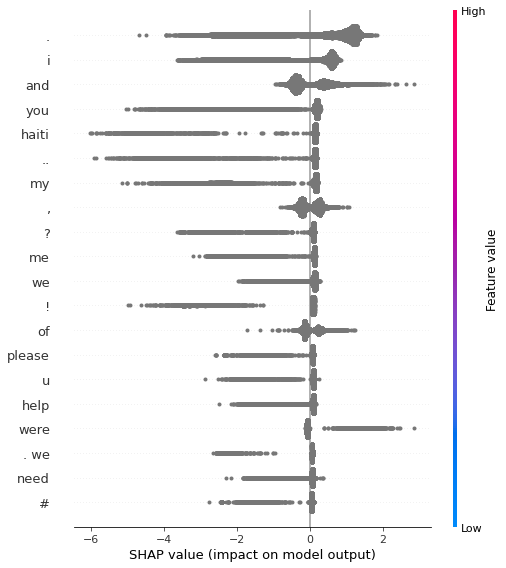

In [79]:
shap.summary_plot(shap_values[1], search.best_estimator_[:-1].fit_transform(input_X), feature_names = search.best_estimator_[0].get_feature_names())

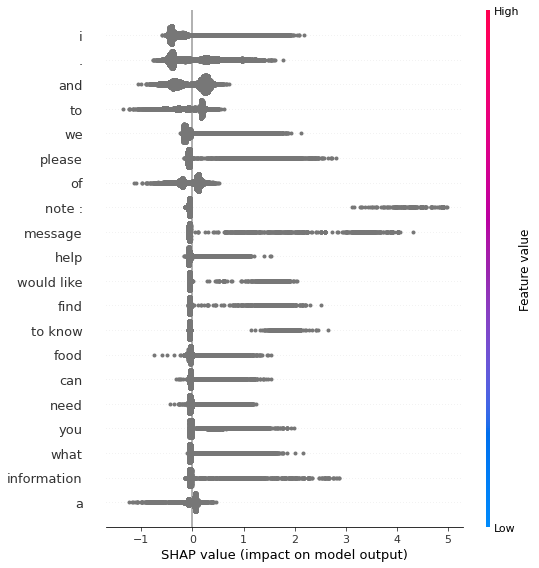

In [83]:
shap.summary_plot(shap_values[0], search.best_estimator_[:-1].fit_transform(input_X), feature_names = search.best_estimator_[0].get_feature_names())

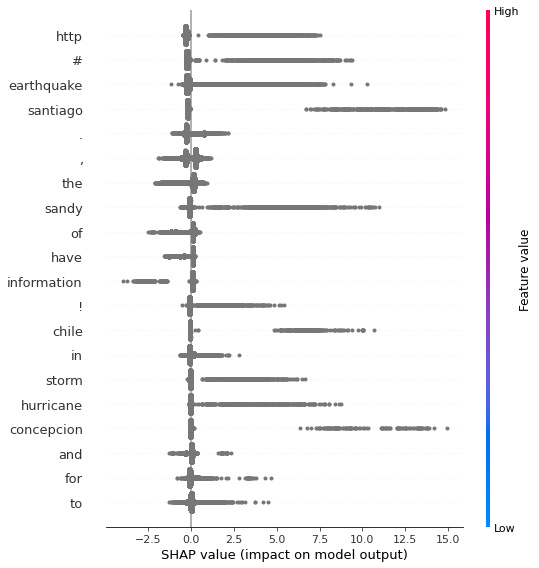

In [84]:
shap.summary_plot(shap_values[2], search.best_estimator_[:-1].fit_transform(input_X), feature_names = search.best_estimator_[0].get_feature_names())

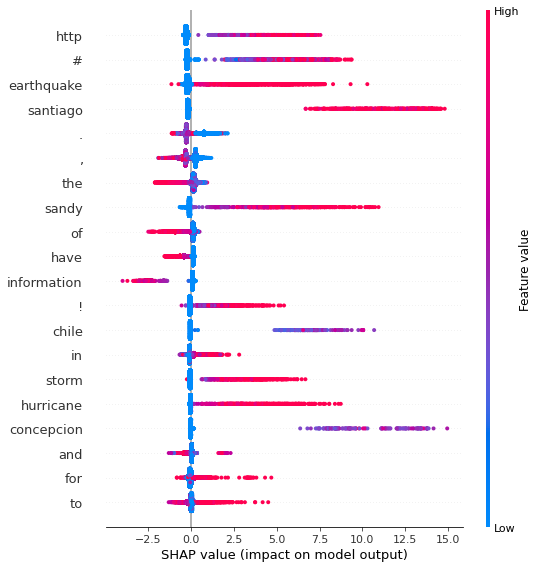

In [82]:
shap.summary_plot(shap_values[2], search.best_estimator_[:-1].fit_transform(input_X).toarray(), feature_names = search.best_estimator_[0].get_feature_names())

In [24]:
search.best_estimator_[-1].feature_importances_

array([914,  34,  13, ...,   0,   6,  56])

In [153]:
l = search.best_estimator_[:-1].fit_transform(input_X)

In [154]:
type(l)

scipy.sparse.csr.csr_matrix

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

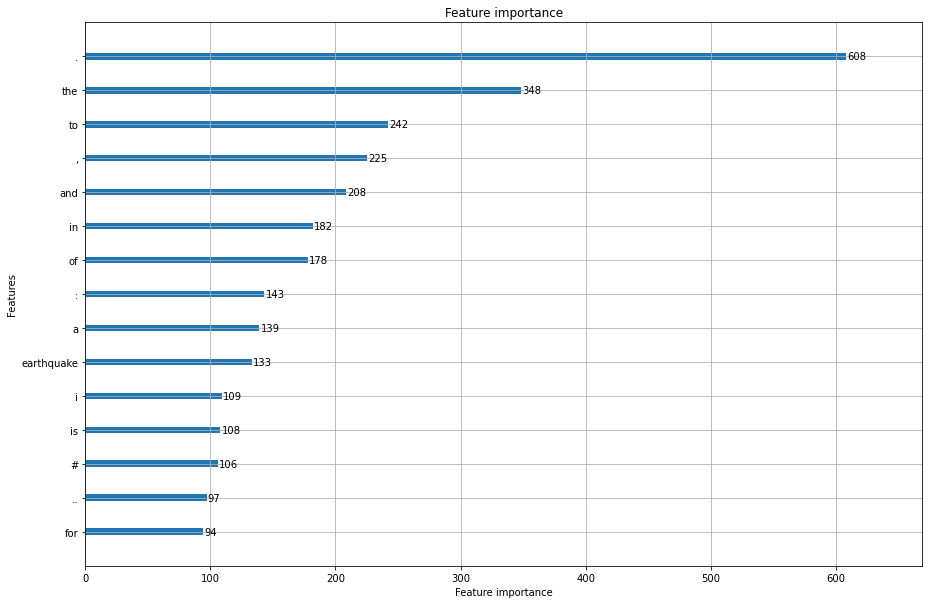

In [105]:
#search.best_estimator_[1].feature_name_ = search.best_estimator_[0].get_feature_names()
plot_importance(search.best_estimator_[-1], max_num_features= 15, figsize=(15,10))

In [104]:
search.best_estimator_[1].booster_.feature_name =  search.best_estimator_[0].get_feature_names#.get_feature_names()

In [75]:
search.best_estimator_[0].get_feature_names()

['!',
 '! !',
 '! #',
 '! i',
 '#',
 '# haiti',
 '# hurricanesandy',
 '# nyc',
 '# sandy',
 '$',
 '%',
 '% of',
 '&',
 "'",
 "''",
 "'' .",
 "'d",
 "'d like",
 "'ll",
 "'m",
 "'m a",
 "'m in",
 "'re",
 "'s",
 "'s a",
 "'s not",
 "'ve",
 '(',
 '( @',
 '( afp',
 ')',
 ') ,',
 ') -',
 ') .',
 ') and',
 ') http',
 ') in',
 ') of',
 ') to',
 '*',
 '* *',
 ',',
 ", ''",
 ', a',
 ', according',
 ', an',
 ', and',
 ', are',
 ', at',
 ', because',
 ', blanket',
 ', but',
 ', can',
 ', especially',
 ', etc',
 ', food',
 ', for',
 ', ha',
 ', have',
 ', he',
 ', how',
 ', i',
 ', if',
 ', in',
 ', including',
 ', is',
 ', it',
 ', my',
 ', no',
 ', on',
 ', one',
 ', or',
 ', particularly',
 ', please',
 ', said',
 ', so',
 ', some',
 ', such',
 ', tent',
 ', the',
 ', there',
 ', they',
 ', to',
 ', wa',
 ', water',
 ', we',
 ', what',
 ', when',
 ', where',
 ', which',
 ', while',
 ', who',
 ', with',
 ', you',
 '-',
 '- a',
 '- the',
 '--',
 '.',
 '. #',
 ". ''",
 '. (',
 '. ..',
 '. a',
 '. h

In [96]:
search.best_estimator_[1].get_booster().feature_names

LGBMClassifier(learning_rate=0.5, max_depth=10)

In [103]:
search.best_estimator_[0].get_feature_names

<bound method CountVectorizer.get_feature_names of TfidfVectorizer(max_features=2000, ngram_range=(1, 2),
                tokenizer=<function tokenize at 0x000002049E61BD90>)>

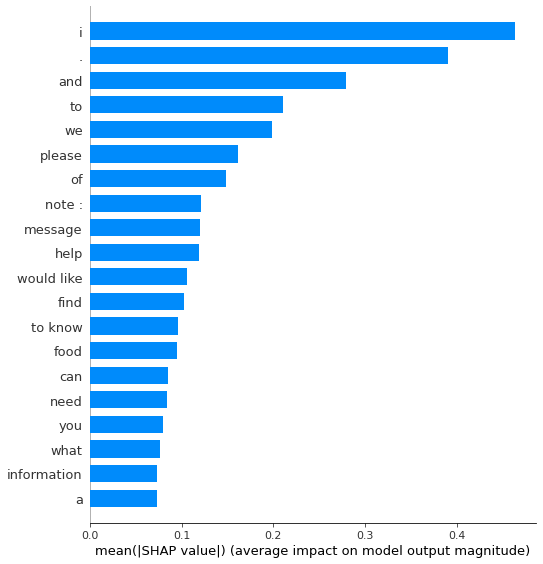

In [109]:
shap.summary_plot(shap_values[0], features=search.best_estimator_[:-1].fit_transform(input_X).toarray(), feature_names=search.best_estimator_[0].get_feature_names(), plot_type='bar')

In [ ]:
shap.summary_plot(shap_values[2], search.best_estimator_[:-1].fit_transform(input_X).toarray(), feature_names = search.best_estimator_[0].get_feature_names())

In [15]:
loaded_model

Pipeline(steps=[('tfidfvect',
                 TfidfVectorizer(max_features=2000, ngram_range=(1, 2),
                                 tokenizer=<function tokenize at 0x00000209CD01D158>)),
                ('multiclassifier',
                 LGBMClassifier(learning_rate=0.5, max_depth=10))])

In [9]:
limeexplainer = LimeTextExplainer(class_names = Y.unique())

In [21]:
my_string =  input_X.iloc[467]
my_string

'Let the radio stations begin with Missions ( q ).'

In [22]:
loaded_model.predict_proba([my_string])

array([[8.92518250e-01, 1.07284491e-01, 1.97259104e-04]])

In [29]:
loaded_model.predict([my_string])

array(['direct'], dtype=object)

In [42]:
exp = limeexplainer.explain_instance( my_string,loaded_model.predict_proba, num_features  = 10, top_labels=3)

split() requires a non-empty pattern match.


In [43]:
exp.as_list()

[('Let', -0.5626011729570071),
 ('begin', -0.20906304185674854),
 ('Missions', 0.1638577469902107),
 ('radio', -0.10993014494602665),
 ('the', 0.06569945157103058),
 ('with', 0.03694484903872326),
 ('q', 0.021251879795121584),
 ('stations', -0.015242366549008457)]

In [44]:
exp.show_in_notebook()

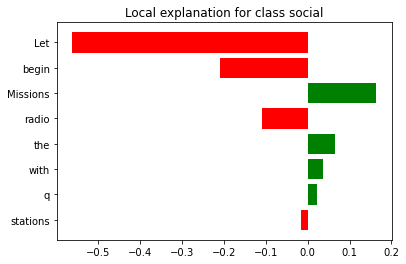

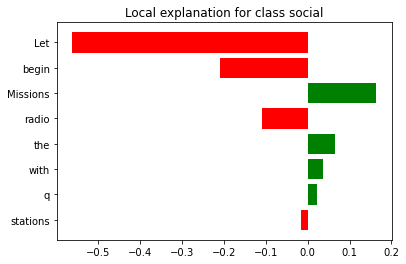

In [54]:
exp.as_pyplot_figure()

In [50]:
loaded_model[-1]

LGBMClassifier(learning_rate=0.5, max_depth=10)

In [53]:
explainer = shap.TreeExplainer(loaded_model[-1])
shap_values = explainer.shap_values(loaded_model[:-1].fit_transform(input_X).toarray())

In [ ]:
shap.force_plot(explainer.expected_value[1], shap_values[1], loaded_model[:-1].fit_transform(input_X).toarray())

shap.plots.force is slow for many thousands of rows, try subsampling your data.
